In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, accuracy_score
import pandas as pd
import numpy as np

In [2]:
f1_scorer = make_scorer(f1_score, zero_division=0)

In [7]:
df = pd.read_csv("species_biome_env_dataset.csv")

In [4]:
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "class_weight": ["balanced"]
}

In [8]:
tuned_metrics = []

# Biome label lookup (applied only after modeling)
biome_lookup = {
    1: "Tropical Forest",
    2: "Temperate Forest",
    3: "Boreal Forest",
    4: "Tropical Grassland",
    5: "Temperate Grassland",
    6: "Desert",
    7: "Shrubland",
    8: "Tundra",
    9: "Flooded Grassland",
    10: "Mangroves",
    11: "Mediterranean",
    12: "Montane",
    13: "Xeric Shrubland",
    14: "Ice and Rock"
}

species_cols = [
    "axolotl", "blue_macaw", "ocelot", "black_iguana", "resplendent_quetzal",
    "coyote", "crested_caracara", "green_turtle", "american_alligator", "asian_elephant"
]

biome_ids = sorted(df["BIOME"].dropna().unique())
tuned_matrix_rf = pd.DataFrame(index=species_cols, columns=[biome_lookup.get(b, f"Biome {b}") for b in biome_ids])

for species in species_cols:
    print(f"\n Tuning Random Forest for: {species}")
    y = df[species].astype(int)

    env_cols = [col for col in df.columns if col.startswith("BIO")]
    biome_encoded = pd.get_dummies(df["BIOME"], prefix="BIOME")
    X = pd.concat([df[env_cols], biome_encoded], axis=1)
    X = X.apply(pd.to_numeric, errors='coerce').replace([np.inf, -np.inf], np.nan)
    X = X.fillna(X.mean(numeric_only=True))
    y = y.loc[X.index]

    if y.value_counts().min() < 2:
        print(f"Skipping {species} due to insufficient class diversity.")
        continue

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    try:
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y, test_size=0.25, random_state=42, stratify=y
        )
    except ValueError as ve:
        print(f"Skipping {species}: {ve}")
        continue

    grid = GridSearchCV(
        estimator=RandomForestClassifier(random_state=42),
        param_grid=param_grid,
        scoring=f1_scorer,
        cv=3,
        n_jobs=-1
    )

    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_

    # Evaluation
    y_pred = best_model.predict(X_test)
    tuned_metrics.append({
        "Species": species,
        "Model": "Random Forest (Tuned)",
        "Best Params": grid.best_params_,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred, zero_division=0),
        "F1": f1_score(y_test, y_pred, zero_division=0)
    })
    print(f"Best F1: {f1_score(y_test, y_pred):.3f} | Params: {grid.best_params_}")

    # Compatibility matrix using predicted probabilities
    probas = best_model.predict_proba(X_scaled)[:, 1]
    df_temp = df.loc[X.index].copy()
    df_temp["pred_prob"] = probas
    biome_avg = df_temp.groupby("BIOME")["pred_prob"].mean()

    for biome_id, prob in biome_avg.items():
        biome_label = biome_lookup.get(biome_id, f"Biome {biome_id}")
        tuned_matrix_rf.loc[species, biome_label] = round(prob, 3)



 Tuning Random Forest for: axolotl
Best F1: 0.025 | Params: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

 Tuning Random Forest for: blue_macaw
Best F1: 0.274 | Params: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

 Tuning Random Forest for: ocelot
Best F1: 0.586 | Params: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}

 Tuning Random Forest for: black_iguana
Best F1: 0.308 | Params: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}

 Tuning Random Forest for: resplendent_quetzal
Best F1: 0.132 | Params: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

 Tuning Random Forest for: coyote
Best F1: 0.834 | Params: {'class_weight': 'balanced', 'max_dept

In [9]:
# Export tuned metrics
tuned_rf_df = pd.DataFrame(tuned_metrics)
tuned_rf_df.to_csv("rf_tuned_metrics.csv", index=False)

# Export compatibility matrix
tuned_matrix_rf = tuned_matrix_rf.fillna("–")
tuned_matrix_rf.to_csv("rf_tuned_matrix.csv")

# Preview
tuned_rf_df.head(), tuned_matrix_rf.head()

/tmp/ipython-input-9-3817649851.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tuned_matrix_rf = tuned_matrix_rf.fillna("–")


(               Species                  Model  \
 0              axolotl  Random Forest (Tuned)   
 1           blue_macaw  Random Forest (Tuned)   
 2               ocelot  Random Forest (Tuned)   
 3         black_iguana  Random Forest (Tuned)   
 4  resplendent_quetzal  Random Forest (Tuned)   
 
                                          Best Params  Accuracy  Precision  \
 0  {'class_weight': 'balanced', 'max_depth': None...  0.647849   0.012563   
 1  {'class_weight': 'balanced', 'max_depth': None...  0.772401   0.163823   
 2  {'class_weight': 'balanced', 'max_depth': None...  0.724014   0.432540   
 3  {'class_weight': 'balanced', 'max_depth': None...  0.846774   0.192893   
 4  {'class_weight': 'balanced', 'max_depth': 10, ...  0.647849   0.071259   
 
      Recall        F1  
 0  1.000000  0.024814  
 1  0.842105  0.274286  
 2  0.908333  0.586022  
 3  0.760000  0.307692  
 4  0.937500  0.132450  ,
                      Tropical Forest  Temperate Forest  Boreal Forest  \
 ax

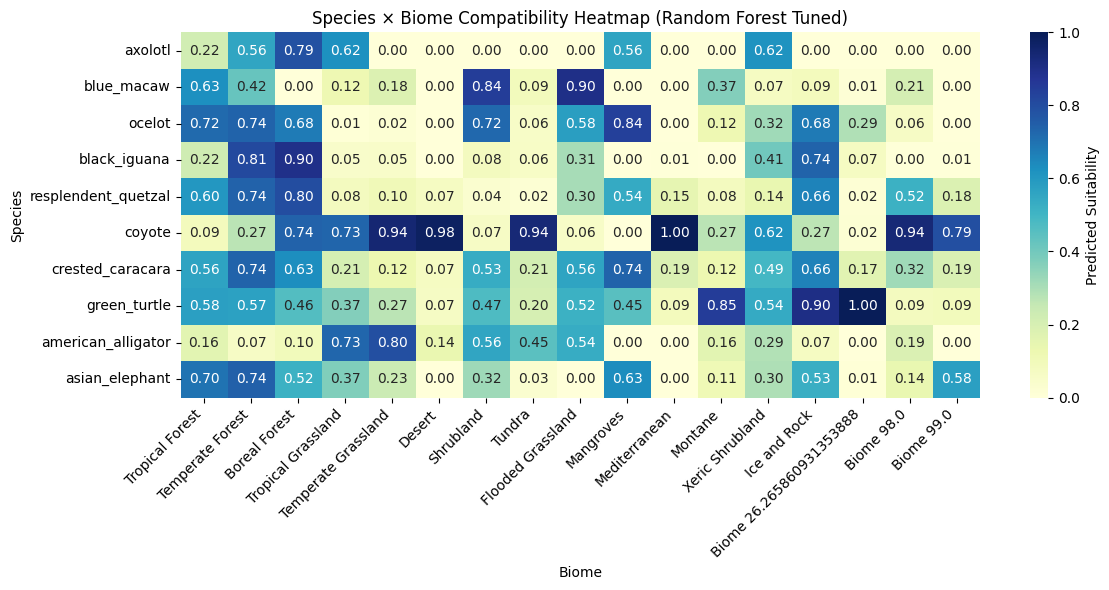

In [12]:
# Heatmap

import matplotlib.pyplot as plt
import seaborn as sns

# Convert values to float (in case of "–")
heatmap_data = tuned_matrix_rf.replace("–", np.nan).astype(float)

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", fmt=".2f", cbar_kws={"label": "Predicted Suitability"})
plt.title("Species × Biome Compatibility Heatmap (Random Forest Tuned)")
plt.xlabel("Biome")
plt.ylabel("Species")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()